# Assignment 2

### Name: Jaimon Thyparambil Thomas
### Student ID: 29566428
### Email ID: jthy0001@student.monash.edu

### Importing necessary Libraries

In [1]:
from pyspark.sql.functions import when,desc
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier,LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics #For caluculating confusion Metrics
import matplotlib.pyplot as plt # For Drawing plots

### Step 01: Import Spark Session and initialize Spark

In [2]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[4]", appName="rain predictor")
spark = SparkSession(sparkContext=sc)

### Step 02: Load the dataset and print the schema and total number of entries

In [3]:
# Load csv file using Spark csv package
data = spark.read.csv('weatherAUS.csv', header=True, inferSchema=True)
print("Total no of records in the dataFrame are",data.count())

Total no of records in the dataFrame are 142193


In [4]:
data.show(truncate=False)

+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date               |Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01 00:00:00|Albury  |13.4   |22.9   |0.6     |NA         |NA      |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |8       |NA      |16.9   |21.8   |

### Step 03: Delete columns from the dataset

In [5]:
# Delete useless data
drop_list = ['Date', 'Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm']

data = data.select([column for column in data.columns if column not in drop_list])
cols = data.columns
data.show(truncate=False)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|13.4   |22.9   |0.6     |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |No       |No          |
|7.4    |25.1   |0       |WNW        |44           |NNW       |WSW       |4           |22          |44         |25         |1010.6     |1007.8     |No       |No          |
|12.9   |25.7   |0       |WSW        |46           |W         |WSW       |19          |26          |38         |30         |1007.6     |1008

### Step 04: Print the number of missing data in each column

Checking if any of the column values is null

In [6]:
for each in data.columns:
    print(each,":",data.filter(data[each].isNull()).count())

MinTemp : 0
MaxTemp : 0
Rainfall : 0
WindGustDir : 0
WindGustSpeed : 0
WindDir9am : 0
WindDir3pm : 0
WindSpeed9am : 0
WindSpeed3pm : 0
Humidity9am : 0
Humidity3pm : 0
Pressure9am : 0
Pressure3pm : 0
RainToday : 0
RainTomorrow : 0


Checking if any of the columns has value NA

In [7]:
for each in data.columns:
    print(each,":",data.filter(data[each] == 'NA').count())

MinTemp : 637
MaxTemp : 322
Rainfall : 1406
WindGustDir : 9330
WindGustSpeed : 9270
WindDir9am : 10013
WindDir3pm : 3778
WindSpeed9am : 1348
WindSpeed3pm : 2630
Humidity9am : 1774
Humidity3pm : 3610
Pressure9am : 14014
Pressure3pm : 13981
RainToday : 1406
RainTomorrow : 0


### Step 05: Fill the missing data with average value and maximum occurrence value.

Checking the datatypes of each columns

In [8]:
data.dtypes

[('MinTemp', 'string'),
 ('MaxTemp', 'string'),
 ('Rainfall', 'string'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'string'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'string'),
 ('WindSpeed3pm', 'string'),
 ('Humidity9am', 'string'),
 ('Humidity3pm', 'string'),
 ('Pressure9am', 'string'),
 ('Pressure3pm', 'string'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

Since all the columns data type looks like string but we know that some of the columns are numbers. So manualyy checking which all columns are numeric and which all columns are categorical

In [9]:
data.head(1)

[Row(MinTemp='13.4', MaxTemp='22.9', Rainfall='0.6', WindGustDir='W', WindGustSpeed='44', WindDir9am='W', WindDir3pm='WNW', WindSpeed9am='20', WindSpeed3pm='24', Humidity9am='71', Humidity3pm='22', Pressure9am='1007.7', Pressure3pm='1007.1', RainToday='No', RainTomorrow='No')]

In [10]:
numericDataColumns = ['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm']

In [11]:
categoricalDataColumns = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

finding the average values for each numeric columns

In [12]:
avgList = []
for each in numericDataColumns:
    avgList.append((each,round(data.filter(data[each] != 'NA').agg({each: "avg"}).collect()[0]["avg("+each+")"],2)))
avgList #This list has all the numeric column names and its respective average values

[('MinTemp', 12.19),
 ('MaxTemp', 23.23),
 ('Rainfall', 2.35),
 ('WindGustSpeed', 39.98),
 ('WindSpeed9am', 14.0),
 ('WindSpeed3pm', 18.64),
 ('Humidity9am', 68.84),
 ('Humidity3pm', 51.48),
 ('Pressure9am', 1017.65),
 ('Pressure3pm', 1015.26)]

Replacing numeric column missing values with its respective average values

In [13]:
for key,val in avgList:
    data = data.withColumn(key,when(data[key] == 'NA',val).otherwise(data[key]))

Finding the most occuring word for categorical columns

In [14]:
moderesult = []
for each in categoricalDataColumns:
    moderesult.append((each,data.groupBy(data[each]).count().sort(desc("count")).collect()[0][each]))
moderesult

[('WindGustDir', 'W'),
 ('WindDir9am', 'N'),
 ('WindDir3pm', 'SE'),
 ('RainToday', 'No')]

Replacing missing values with most occuring values

In [15]:
for key,val in moderesult:
    data = data.withColumn(key,when(data[key] == 'NA',val).otherwise(data[key]))

Cross verifying if all the NA is been replaced or not

In [16]:
for each in data.columns:
    print(each,":",data.filter(data[each] == 'NA').count())

MinTemp : 0
MaxTemp : 0
Rainfall : 0
WindGustDir : 0
WindGustSpeed : 0
WindDir9am : 0
WindDir3pm : 0
WindSpeed9am : 0
WindSpeed3pm : 0
Humidity9am : 0
Humidity3pm : 0
Pressure9am : 0
Pressure3pm : 0
RainToday : 0
RainTomorrow : 0


Looks like all the NA is been replaced. Now checking wheather the average and most occuring word has changed for each column

In [17]:
newAvgList = []
for each in numericDataColumns:
    newAvgList.append((each,round(data.filter(data[each] != 'NA').agg({each: "avg"}).collect()[0]["avg("+each+")"],2)))
newAvgList

[('MinTemp', 12.19),
 ('MaxTemp', 23.23),
 ('Rainfall', 2.35),
 ('WindGustSpeed', 39.98),
 ('WindSpeed9am', 14.0),
 ('WindSpeed3pm', 18.64),
 ('Humidity9am', 68.84),
 ('Humidity3pm', 51.48),
 ('Pressure9am', 1017.65),
 ('Pressure3pm', 1015.26)]

In [18]:
newModeresult = []
for each in categoricalDataColumns:
    newModeresult.append((each,data.groupBy(data[each]).count().sort(desc("count")).collect()[0][each]))
newModeresult

[('WindGustDir', 'W'),
 ('WindDir9am', 'N'),
 ('WindDir3pm', 'SE'),
 ('RainToday', 'No')]

Looks like Both most occuring words of categorical columns and average of numeric columns has not been changed

### Step 06: Data transformation

Checking the datatype of each columns

In [19]:
data.dtypes

[('MinTemp', 'string'),
 ('MaxTemp', 'string'),
 ('Rainfall', 'string'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'string'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'string'),
 ('WindSpeed3pm', 'string'),
 ('Humidity9am', 'string'),
 ('Humidity3pm', 'string'),
 ('Pressure9am', 'string'),
 ('Pressure3pm', 'string'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

Converting numeric columns to type double

In [20]:
for each in numericDataColumns:
    data = data.withColumn(each, data[each].cast("double"))
data.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'double'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [21]:
stages = []
for categoricalCol in categoricalDataColumns:
    # Assigning a numeric index value to each category
    # Why do you do this: to sequence between categories
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    
    #Convert indexed categories to one-hot encoded variables (classVec)
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    
    #When printing steps, a binary vector is added to the end of each line.
    stages += [stringIndexer, encoder]

In [22]:
label_stringIdx = StringIndexer(inputCol = 'RainTomorrow', outputCol = 'label')
stages += [label_stringIdx]

### Step 07: Create the feature vector and divide the dataset

In [23]:
assemblerInputs = [c + "classVec" for c in categoricalDataColumns] + numericDataColumns
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
stages += [assembler]
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
data = pipelineModel.transform(data)
data.show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+----------------+-------------------+---------------+------------------+---------------+------------------+--------------+-----------------+-----+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|WindGustDirIndex|WindGustDirclassVec|WindDir9amIndex|WindDir9amclassVec|WindDir3pmIndex|WindDir3pmclassVec|RainTodayIndex|RainTodayclassVec|label|            features|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+----------------+-------------------+---------------+------------------+---------------+------------------+--------------+-----------------+-----+-----

In [24]:
selectedCols = ['label', 'features'] + cols
data = data.select(selectedCols)
data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



Splitting the data into training and test set

In [25]:
train, test = data.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 99709
Test Dataset Count: 42484


## C. Apply Machine Learning Algorithms
### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.

In [26]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")
binaryEvaluator = BinaryClassificationEvaluator()

### Decision Tree

In [27]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dtModel = dt.fit(train)
dtPredictions = dtModel.transform(test)
dtPredictions.select("prediction", "label").show(5)
dtAccuracy = evaluator.evaluate(dtPredictions)
dtROC = binaryEvaluator.evaluate(dtPredictions)
print("Accuracy",dtAccuracy)
print('Test Area Under ROC',dtROC )

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows

Accuracy 0.8337020996139723
Test Area Under ROC 0.28445439238903747


### Random Forest

In [28]:
rf = RandomForestClassifier(labelCol="label",featuresCol="features", numTrees=100)
rfModel = rf.fit(train)
rfPredictions = rfModel.transform(test)
rfPredictions.select("prediction", "label").show(5)
rfAccuracy = evaluator.evaluate(rfPredictions)
rfROC = binaryEvaluator.evaluate(rfPredictions)
print("Accuracy",rfAccuracy)
print('Test Area Under ROC',rfROC )

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows

Accuracy 0.8210855851614726
Test Area Under ROC 0.8270589422720775


### Logistic Regression

In [29]:
# Create an initial model using the train set.
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',    maxIter=10)
lrModel = lr.fit(train)
lrPredictions = lrModel.transform(test)
lrAccuracy = evaluator.evaluate(lrPredictions)
lrROC = binaryEvaluator.evaluate(lrPredictions)
print("Accuracy",lrAccuracy)
print('Test Area Under ROC',lrROC )

Accuracy 0.8160954712362302
Test Area Under ROC 0.8106452782245887


### Gradient Boosting

In [30]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label',maxIter=10)
gbtModel = gbt.fit(train)
gbPredictions = gbtModel.transform(test)
gbAccuracy = evaluator.evaluate(gbPredictions)
gbROC = binaryEvaluator.evaluate(gbPredictions)
print("Accuracy",gbAccuracy)
print('Test Area Under ROC',gbROC )

Accuracy 0.8377506826099237
Test Area Under ROC 0.8498639624170983


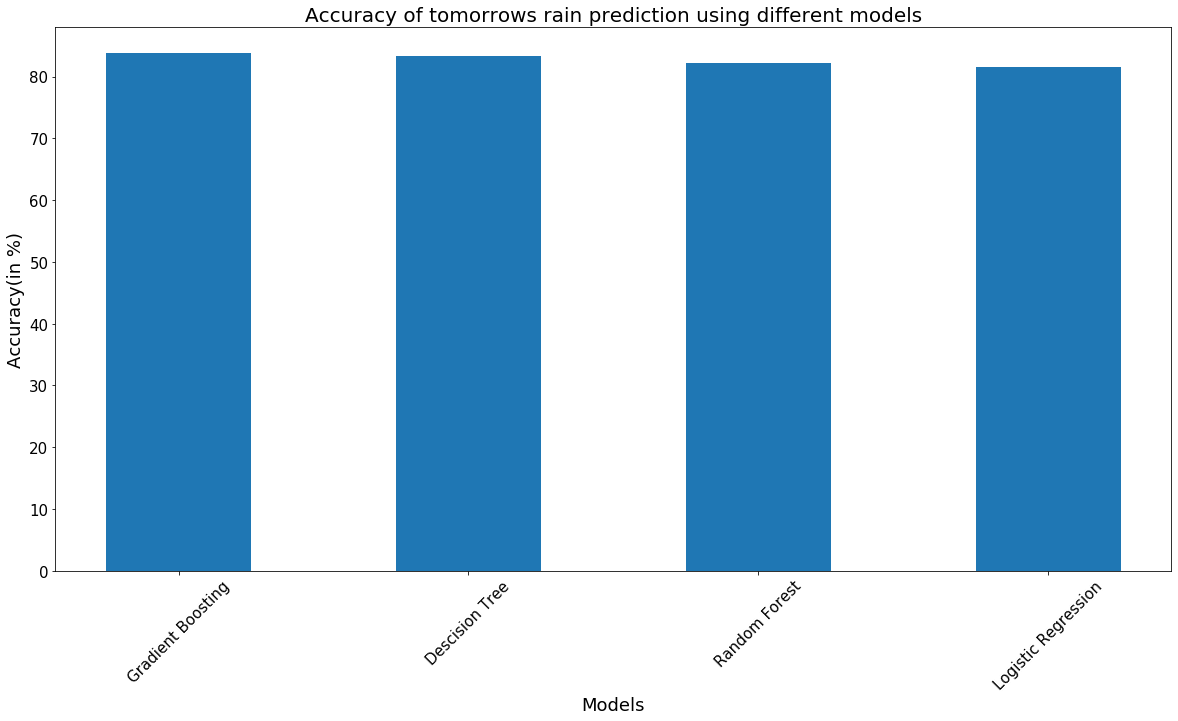

In [31]:
values = [("Descision Tree", dtAccuracy), ("Random Forest", rfAccuracy), ("Logistic Regression", lrAccuracy),\
          ("Gradient Boosting", gbAccuracy)]
values = sorted(values, key=lambda x: x[1], reverse=True)
models = [key for key,val in values]
Accuracy = [val for key,val in values]
Accuracy = [round(each*100,2) for each in Accuracy]

plt.figure(figsize = (20,10))
plt.bar(models, Accuracy, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Models',fontsize=18)
plt.ylabel('Accuracy(in %)',fontsize=18)
plt.title('Accuracy of tomorrows rain prediction using different models',fontsize=20)

plt.show()

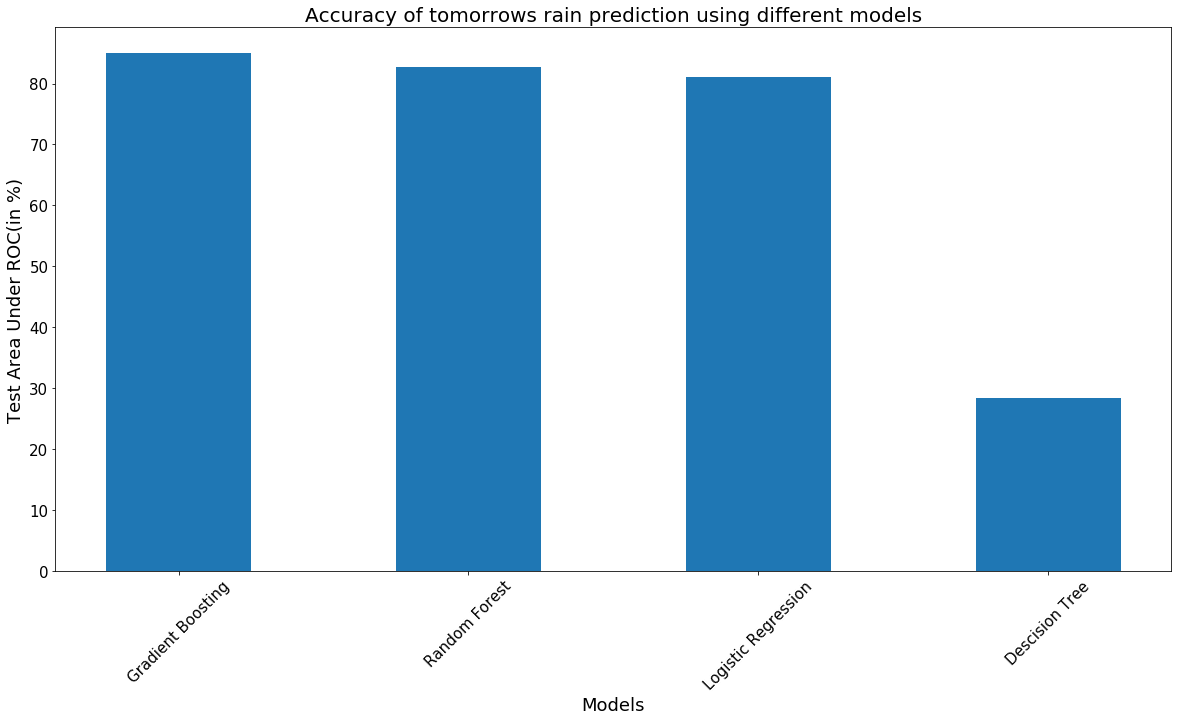

In [32]:
values = [("Descision Tree", dtROC), ("Random Forest", rfROC), ("Logistic Regression", lrROC),\
          ("Gradient Boosting", gbROC)]
values = sorted(values, key=lambda x: x[1], reverse=True)
models = [key for key,val in values]
Accuracy = [val for key,val in values]
Accuracy = [round(each*100,2) for each in Accuracy]

plt.figure(figsize = (20,10))
plt.bar(models, Accuracy, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Models',fontsize=18)
plt.ylabel('Test Area Under ROC(in %)',fontsize=18)
plt.title('Accuracy of tomorrows rain prediction using different models',fontsize=20)

plt.show()

From the Plots we can clearly see that model created by gradient boosting has highest accuracy compared to other models

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?

### Decision Tree

In [33]:
dtmetrics = MulticlassMetrics(dtPredictions.select("prediction", "label").rdd)
confusionMetrics = dtmetrics.confusionMatrix().values
truePositive = confusionMetrics[0]
falsePositive = confusionMetrics[1]
falseNegative = confusionMetrics[2]
trueNegative = confusionMetrics[3]

dtRecall = truePositive/(truePositive+falseNegative)
dtPrecision = truePositive/(truePositive+falsePositive)
dtF1Score = 2*(dtPrecision*dtRecall)/(dtPrecision+dtRecall)

print("Model : Decision Tree")
print("-----------------------------")
print("Recall :",dtRecall)
print("Precision :",dtPrecision)
print("F1 Score :",dtF1Score)

Model : Decision Tree
-----------------------------
Recall : 0.9649848024316109
Precision : 0.8429940787552109
F1 Score : 0.8998738680007369


### Random Forest

In [34]:
rfmetrics = MulticlassMetrics(rfPredictions.select("prediction", "label").rdd)
confusionMetrics = rfmetrics.confusionMatrix().values
truePositive = confusionMetrics[0]
falsePositive = confusionMetrics[1]
falseNegative = confusionMetrics[2]
trueNegative = confusionMetrics[3]

rfRecall = truePositive/(truePositive+falseNegative)
rfPrecision = truePositive/(truePositive+falsePositive)
rfF1Score = 2*(rfPrecision*rfRecall)/(rfPrecision+rfRecall)

print("Model : Random Forest")
print("-----------------------------")
print("Recall :",dtRecall)
print("Precision :",dtPrecision)
print("F1 Score :",dtF1Score)

Model : Random Forest
-----------------------------
Recall : 0.9649848024316109
Precision : 0.8429940787552109
F1 Score : 0.8998738680007369


### Gradient Boosting

In [35]:
gbmetrics = MulticlassMetrics(gbPredictions.select("prediction", "label").rdd)
confusionMetrics = gbmetrics.confusionMatrix().values
truePositive = confusionMetrics[0]
falsePositive = confusionMetrics[1]
falseNegative = confusionMetrics[2]
trueNegative = confusionMetrics[3]

gbRecall = truePositive/(truePositive+falseNegative)
gbPrecision = truePositive/(truePositive+falsePositive)
gbF1Score = 2*(gbPrecision*gbRecall)/(gbPrecision+gbRecall)

print("Model : Gradient Boosting")
print("-----------------------------")
print("Recall :",gbRecall)
print("Precision :",gbPrecision)
print("F1 Score :",gbF1Score)

Model : Gradient Boosting
-----------------------------
Recall : 0.9533738601823708
Precision : 0.8540776038121171
F1 Score : 0.9009982046678635


### Logistic Regression

In [36]:
lrmetrics = MulticlassMetrics(lrPredictions.select("prediction", "label").rdd)
confusionMetrics = lrmetrics.confusionMatrix().values
truePositive = confusionMetrics[0]
falsePositive = confusionMetrics[1]
falseNegative = confusionMetrics[2]
trueNegative = confusionMetrics[3]

lrRecall = truePositive/(truePositive+falseNegative)
lrPrecision = truePositive/(truePositive+falsePositive)
lrF1Score = 2*(lrPrecision*lrRecall)/(lrPrecision+lrRecall)

print("Model : Gradient Boosting")
print("-----------------------------")
print("Recall :",lrRecall)
print("Precision :",lrPrecision)
print("F1 Score :",lrF1Score)

Model : Gradient Boosting
-----------------------------
Recall : 0.9343465045592705
Precision : 0.8446679306460033
F1 Score : 0.8872469080570909


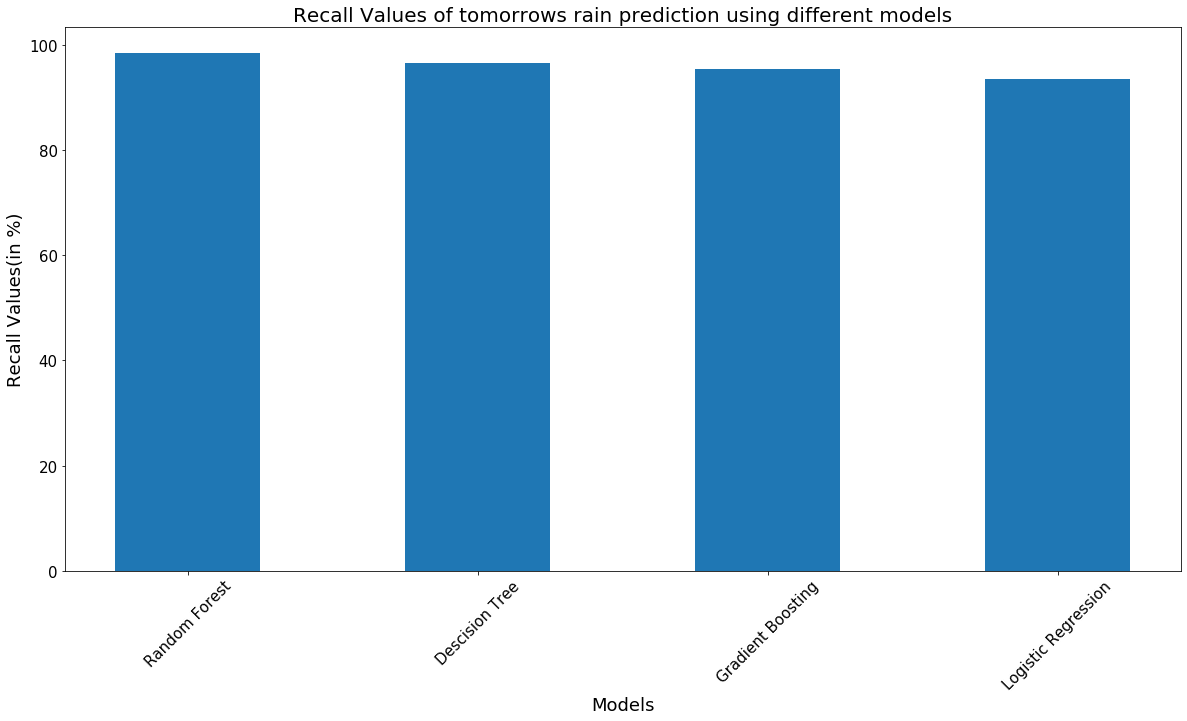

In [37]:
values = [("Descision Tree", dtRecall), ("Random Forest", rfRecall), ("Logistic Regression", lrRecall),\
          ("Gradient Boosting", gbRecall)]
values = sorted(values, key=lambda x: x[1], reverse=True)
models = [key for key,val in values]
Accuracy = [val for key,val in values]
Accuracy = [round(each*100,2) for each in Accuracy]

plt.figure(figsize = (20,10))
plt.bar(models, Accuracy, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Models',fontsize=18)
plt.ylabel('Recall Values(in %)',fontsize=18)
plt.title('Recall Values of tomorrows rain prediction using different models',fontsize=20)

plt.show()

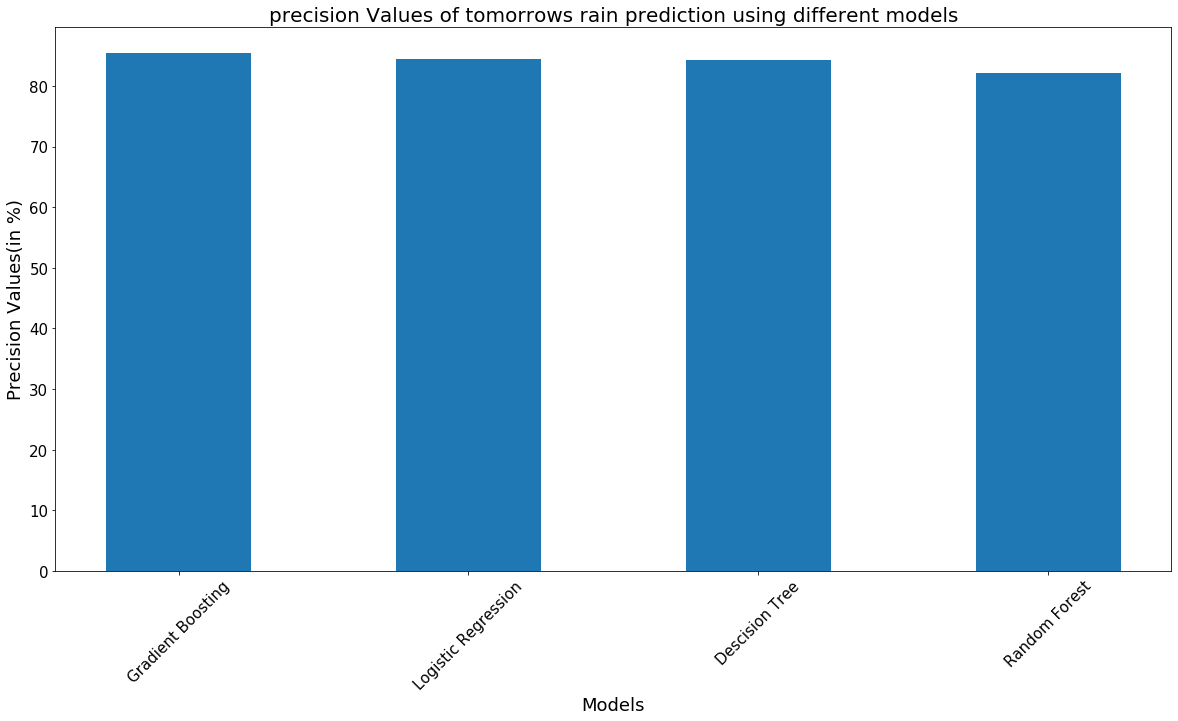

In [38]:
values = [("Descision Tree", dtPrecision), ("Random Forest", rfPrecision), ("Logistic Regression", lrPrecision),\
          ("Gradient Boosting", gbPrecision)]
values = sorted(values, key=lambda x: x[1], reverse=True)
models = [key for key,val in values]
Accuracy = [val for key,val in values]
Accuracy = [round(each*100,2) for each in Accuracy]

plt.figure(figsize = (20,10))
plt.bar(models, Accuracy, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Models',fontsize=18)
plt.ylabel('Precision Values(in %)',fontsize=18)
plt.title('precision Values of tomorrows rain prediction using different models',fontsize=20)

plt.show()

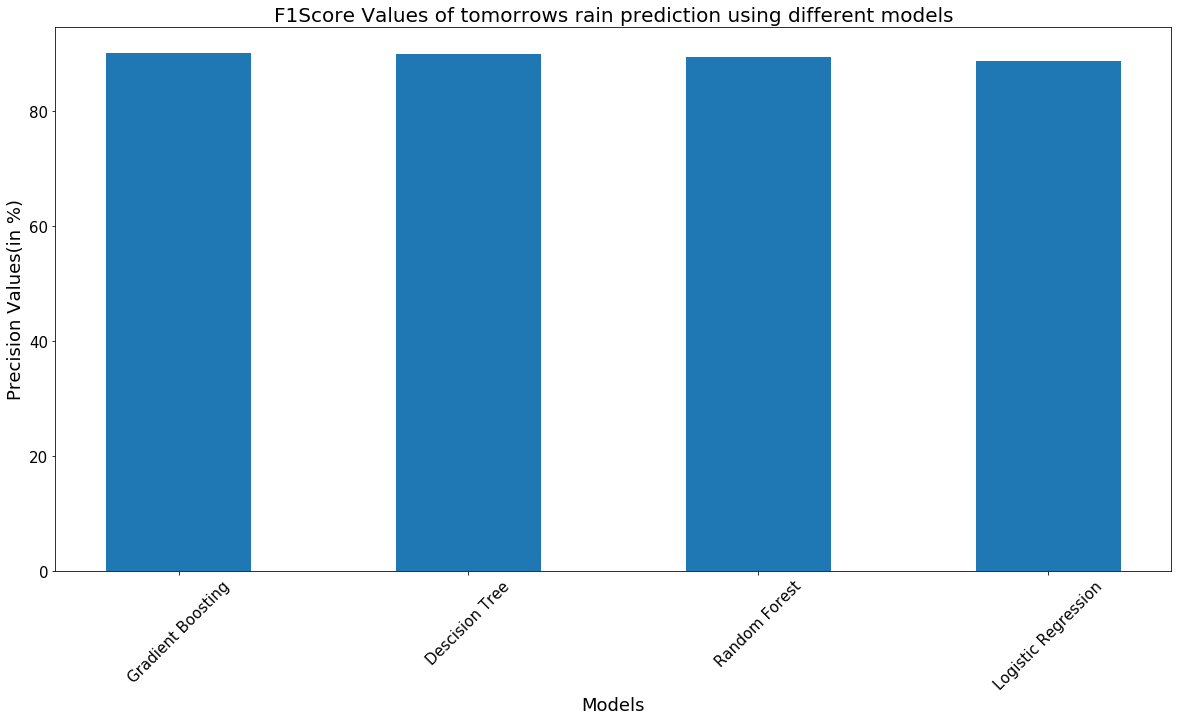

In [39]:
values = [("Descision Tree", dtF1Score), ("Random Forest", rfF1Score), ("Logistic Regression", lrF1Score),\
          ("Gradient Boosting", gbF1Score)]
values = sorted(values, key=lambda x: x[1], reverse=True)
models = [key for key,val in values]
Accuracy = [val for key,val in values]
Accuracy = [round(each*100,2) for each in Accuracy]

plt.figure(figsize = (20,10))
plt.bar(models, Accuracy, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Models',fontsize=18)
plt.ylabel('Precision Values(in %)',fontsize=18)
plt.title('F1Score Values of tomorrows rain prediction using different models',fontsize=20)

plt.show()

From the plots its clear that F1 score and precision is maximum for Gradient Boosting and recall is maximum for random forest

### Accuracy of each predictions can be improved using methods Like

### Cross Validation
The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

### Fine Tuning the Models
Models performance can be further improved by fine tunning various features while creating the model like numTrees in random forest and maxIter in logistics regression and gradient boosting etc changing these values can infulence the overall accuracy of the model. So by fine tuning and finding which value is correct for the model we can increase the overall accuracy of the model

### Example of increasing the accuracy by cross validation

In [40]:
# ParamGridBuilder() used in grid search-based models
# Parametric to ParamGridBuilder.addGrid() is a pair.
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,    evaluator=evaluator, numFolds=5)
 
# Run cross validation
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
gbNewAccuracy = evaluator.evaluate(predictions)
print("---------------------------------")
print("Gradient Boosting Accuracy before cross validation is", gbAccuracy)
print("Gradient Boosting Accuracy After cross validation is", gbNewAccuracy)

---------------------------------
Gradient Boosting Accuracy before cross validation is 0.8377506826099237
Gradient Boosting Accuracy After cross validation is 0.8454476979568779


Here we can clearly see that the accuracy of model created by gradient boosting has increased after cross validation